# **Importing Libraries**

In [ ]:
import os
import nltk
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import word_tokenize
from urllib import request
from bs4 import BeautifulSoup
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from nltk.text import TextCollection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# **Dataset cleaning and preprocessing**

In [ ]:
df= pd.read_csv("sentiment.csv", encoding = "ISO-8859-1", engine="python")

In [ ]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
col=['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.columns=col

In [ ]:
df.tail()

,sentiment,id,date,query,user_id,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [ ]:
print('length of data is', len(df))

length of data is 1599999


In [ ]:
df.shape

(1599999, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   id         1599999 non-null  int64 
 2   date       1599999 non-null  object
 3   query      1599999 non-null  object
 4   user_id    1599999 non-null  object
 5   text       1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df.dtypes

,0
sentiment,int64
id,int64
date,object
query,object
user_id,object
text,object


In [ ]:
df.isnull().sum()

,0
sentiment,0
id,0
date,0
query,0
user_id,0
text,0


In [ ]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [ ]:
df.drop_duplicates(subset='text',inplace=True)

In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
4,791281
0,790184


In [ ]:
lab_to_sentiment = {0:0, 4:1}
def label_decoder(label):
    return lab_to_sentiment[label]
df['sentiment'] = df['sentiment'].map(label_decoder)
df.sample(10)

,sentiment,text
1489663,1,@daniecetracey aah save some for me! xx
637679,0,OMG- I just went from having 200 followers to ...
299210,0,Okay did not care for leonardos at all. The ro...
14832,0,"god, i need to get a life... a new low adding ..."
149075,0,i've been throwing up all day. i feel like i'v...
605115,0,Graduation is less than a month away. What do ...
783231,0,Wish the love of my life was here hanging out....
489401,0,It might be time to update my &quot;Favorite T...
1439103,1,@helensharvest Mine too Helen! Love your websi...
404168,0,ITS OFFICIAL THIS YEAR SUCKS BIG TIME!!!!


In [ ]:
data_pos = df[df['sentiment'] == 1]
data_neg = df[df['sentiment'] == 0]

In [ ]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [ ]:
data = pd.concat([data_pos, data_neg])
data.shape

(1581465, 2)

# **Removal of stopwords**

In [ ]:
data['text']=data['text'].str.lower()

In [ ]:
data['text'].sample(5)

,text
195281,"@tommcfly plz say &quot;happy birthday or , roni &amp; mickey!&quot; plz plz plz x"
1142238,i love my senior dancers... senior showcase was amazing. you guys rock!
24700,"catching up on all the tv i missed this week, waiting for the 'rents to get here and take a bunch of my shit back home."
280424,@ayeyi chen! i dont know if i want to buy na! waaaa
1173275,@audioworm my first thought was that he was building some kind of trebuchet. i was right


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords_list = stopwords.words('english')
stopwords_list[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
import string
STOPWORDS = set(stopwords_list)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'].head()

english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [ ]:
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text']= data['text'].apply(lambda x: cleaning_email(x))
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))

In [ ]:
data['text'].head(10)

,text
799999,love healthuandpets u guys r best
800000,im meeting one besties tonight cant wait girl talk
800001,darealsunisakim thanks twitter add sunisa got meet hin show dc area sweetheart
800002,sick really cheap hurts much eat real food plus friends make soup
800003,lovesbrooklyn effect everyone
800004,productoffear tell burst laughing really loud thanks making come sulk
800005,rkeithhill thans response ihad already find answer
800006,keepinupwkris jealous hope great time vegas like acms love show
800007,tommcfly ah congrats mr fletcher finally joining twitter
800008,evoip responded stupid cat helping type forgive errors


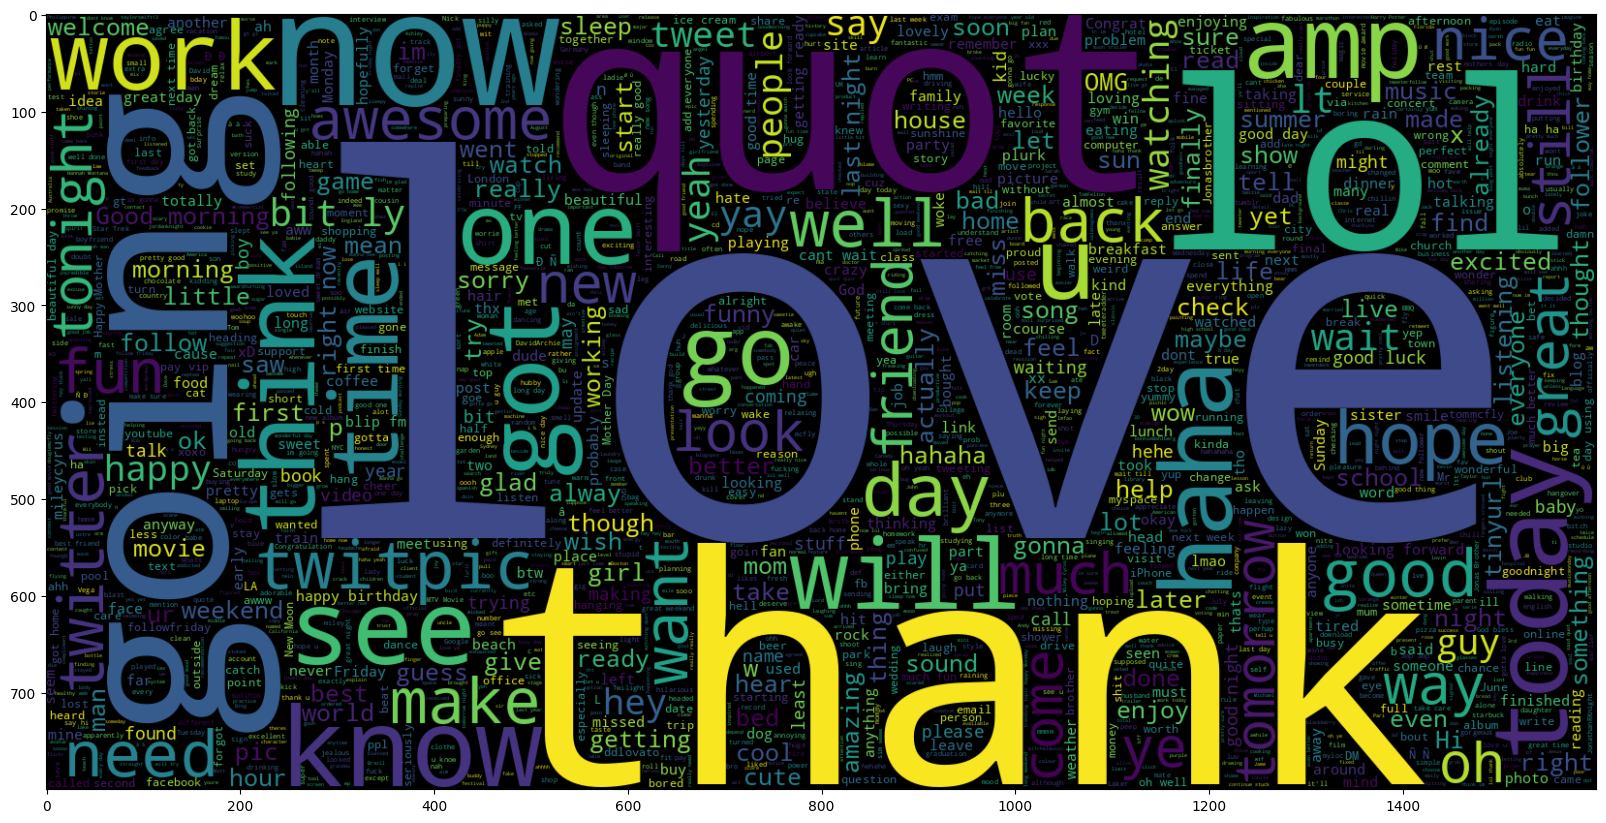

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_pos.text))
plt.imshow(wc , interpolation = 'bilinear')

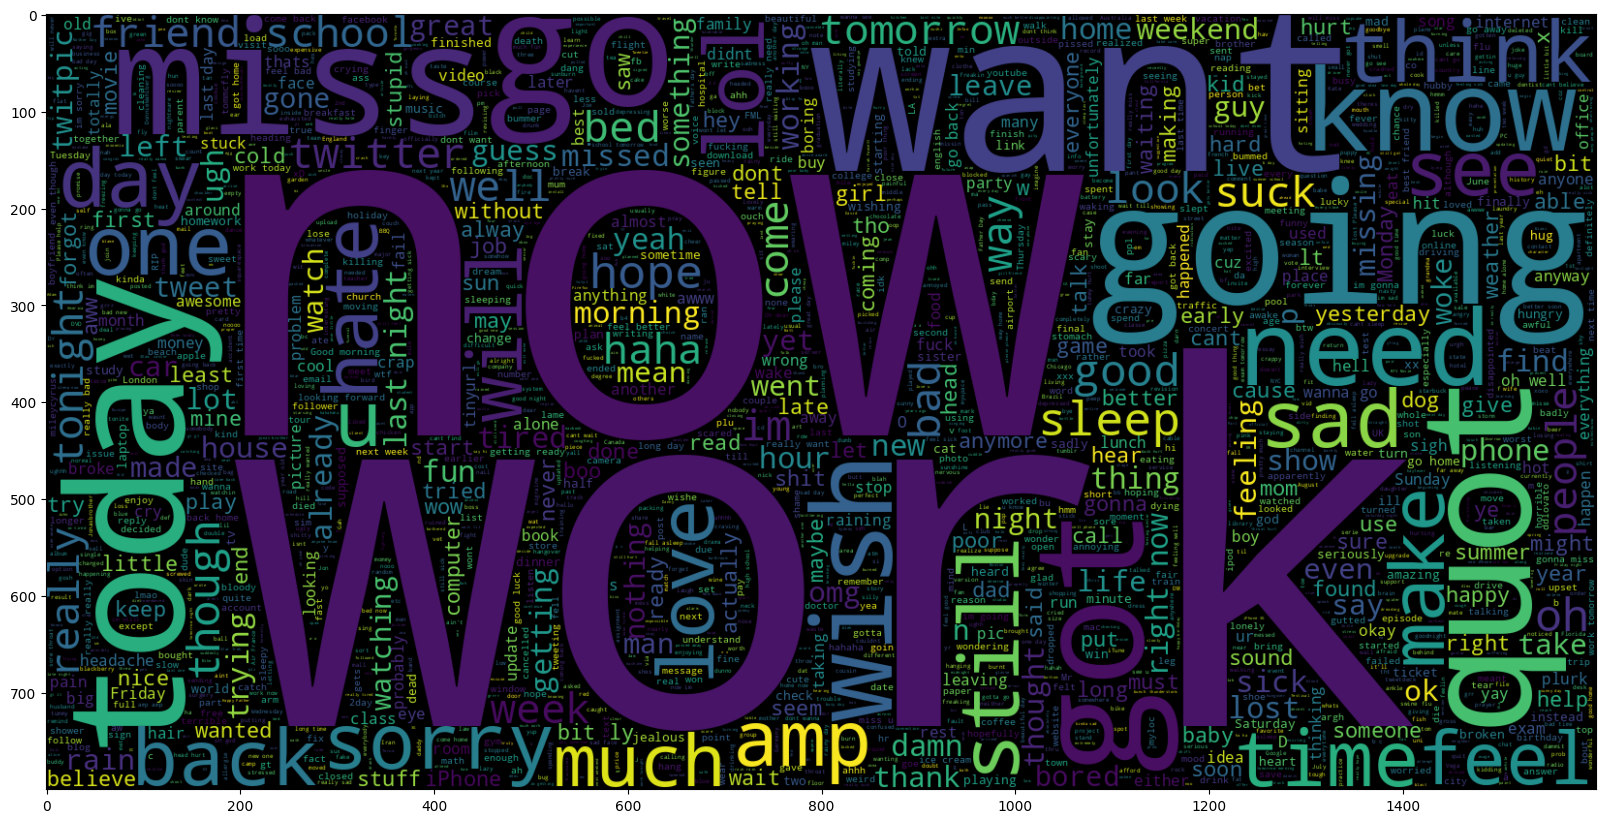

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_neg.text))
plt.imshow(wc , interpolation = 'bilinear')

# **Data Tokenization**

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tokenized_tweets = [nltk.word_tokenize(tweet) for tweet in data.text]

In [ ]:
tokenized_tweets[:5]

[['love', 'healthuandpets', 'u', 'guys', 'r', 'best'],
 ['im',
  'meeting',
  'one',
  'besties',
  'tonight',
  'cant',
  'wait',
  'girl',
  'talk'],
 ['darealsunisakim',
  'thanks',
  'twitter',
  'add',
  'sunisa',
  'got',
  'meet',
  'hin',
  'show',
  'dc',
  'area',
  'sweetheart'],
 ['sick',
  'really',
  'cheap',
  'hurts',
  'much',
  'eat',
  'real',
  'food',
  'plus',
  'friends',
  'make',
  'soup'],
 ['lovesbrooklyn', 'effect', 'everyone']]

In [ ]:
data['text']=tokenized_tweets

In [ ]:
data.head()

,sentiment,text
799999,1,"[love, healthuandpets, u, guys, r, best]"
800000,1,"[im, meeting, one, besties, tonight, cant, wai..."
800001,1,"[darealsunisakim, thanks, twitter, add, sunisa..."
800002,1,"[sick, really, cheap, hurts, much, eat, real, ..."
800003,1,"[lovesbrooklyn, effect, everyone]"


# **Stemming and Lemmatization**

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    stemmed_data = []
    for words in data:
        stemmed_words = [st.stem(word) for word in words]
        stemmed_data.append(stemmed_words)
    return stemmed_data

In [ ]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    lemmatized_data = []
    for words in data:
        lemmatized_words = [lm.lemmatize(word) for word in words]
        lemmatized_data.append(lemmatized_words)
    return lemmatized_data

In [ ]:
data['text'] = stemming_on_text(data['text'])
data['text'] = lemmatizer_on_text(data['text'])

In [ ]:
data['text'].sample(7)

,text
485472,"[lifsolkc, know]"
112610,"[scratch, that, tablesevenorg, demolish, need, done, probabl, due, poor, foundat, built]"
963070,"[photoshoot, sear, smooth, problem]"
1397104,"[panacea, friend, wed, wear, yellow, dress, clue, color, makeup, use, suggest]"
22009,"[sit, home, bore, doesnt, want, go, back, school, tomorrow]"
588888,"[glad, lee, kuan, yew, doesnât, want, see, lim, kit, siang, httpbitlyvcc, johnong, demonick, skyburi, kyspeak, nikicheong]"
1235539,"[follow, delain, twitter, win, latest, singl, exclus, shirtquot]"


In [ ]:
data['text'] = [" ".join(doc) for doc in data['text']]

In [ ]:
data['text'].sample(7)

,text
901929,eat one big subway cooki glass warm milk yum
376477,benski eh realli flu come take easi sorta
247515,let come in oh yeah probabl muddi foot
612395,woke up way gym tire
1150729,httptwitpiccombijh view room super cold room freez rain hel
194707,moro go malaysia againearli morn
1109611,httptwitpiccomqmf oh amp say doesnt like pic edit psh pic gorgg


# **Separating input feature and label**

In [ ]:
X=data.text
y=data.sentiment
print(X)
print(y)

799999                      love healthuandpet u guy r best
800000        im meet one besti tonight cant wait girl talk
800001    darealsunisakim thank twitter add sunisa got m...
800002    sick realli cheap hurt much eat real food plu ...
800003                         lovesbrooklyn effect everyon
                                ...                        
799994            sick spend day lay bed listen taylorswift
799995                                           gmail down
799996                                 rest peac farrah sad
799997       ericurban sound like rival flag ad much though
799998    resit exam summer wish work harder first year uni
Name: text, Length: 1581465, dtype: object
799999    1
800000    1
800001    1
800002    1
800003    1
         ..
799994    0
799995    0
799996    0
799997    0
799998    0
Name: sentiment, Length: 1581465, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify = y,random_state = 2)
print(X.shape,X_train.shape,X_test.shape)
print(y.shape,y_train.shape,y_test.shape)

(1581465,) (1265172,) (316293,)
(1581465,) (1265172,) (316293,)


In [ ]:
print(X_train)

931585     iamkhayyam let start am slumber back am am sta...
540843                                      sister come help
1409058    fancymelissa thank u melissa im excit hope gre...
1254359                                misskellyo ju watchin
890803                                 text lot fo peopl lol
                                 ...                        
381548     lronjaii amm nt happi wt happen got yo bk day ...
1422772       love littl girl sign said quotit ameoba itquot
532575                             almost time twit got leav
195157                                                  work
614876                    damn it day day willpow stick diet
Name: text, Length: 1265172, dtype: object


In [ ]:
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [ ]:
print(X_train_vect)

  (0, 321844)	0.18314667383191544
  (0, 612305)	0.21742700109642493
  (0, 569282)	0.16234050858539306
  (0, 490264)	0.4332536337255285
  (0, 554657)	0.1280407096794879
  (0, 38898)	0.13217138250672406
  (0, 508161)	0.32156326560655374
  (0, 16257)	0.5478492977513342
  (0, 520484)	0.3208705349132933
  (0, 327336)	0.16577905097871973
  (0, 261139)	0.37050447332291114
  (1, 203841)	0.5675211091434527
  (1, 97763)	0.47234144196767835
  (1, 504516)	0.6743985119174564
  (2, 422059)	0.2897918501194078
  (2, 189776)	0.2360848412639627
  (2, 211685)	0.22147769103461198
  (2, 154984)	0.2830348343054338
  (2, 265580)	0.15724568823431284
  (2, 361142)	0.4609807761404517
  (2, 543449)	0.20836632634352956
  (2, 158666)	0.6711762345913171
  (3, 590332)	0.5050755866744499
  (3, 296047)	0.4943104337409461
  (3, 371057)	0.7074997150814253
  :	:
  (1265167, 477234)	0.2443950298627865
  (1265167, 615945)	0.2436327794176451
  (1265167, 198122)	0.162100332378176
  (1265167, 187974)	0.13147789460998252
  (12

In [ ]:
print(X_test_vect)

  (0, 520984)	0.3961572401349975
  (0, 339037)	0.26110275792168397
  (0, 262692)	0.4012382505863655
  (0, 84288)	0.4684046630385768
  (0, 80082)	0.6280841733433685
  (1, 512698)	0.24071720632407495
  (1, 475817)	0.33498012167164226
  (1, 467025)	0.5747251147560678
  (1, 433467)	0.2245153527190889
  (1, 385203)	0.3877208196829281
  (1, 364751)	0.34635789514541665
  (1, 339037)	0.16608665199873582
  (1, 276041)	0.38891058356532004
  (2, 589200)	0.19210207445247232
  (2, 576655)	0.24732746910225184
  (2, 527493)	0.19442649844033177
  (2, 498376)	0.21989163153955466
  (2, 389051)	0.1607232681178544
  (2, 372943)	0.46896519149247057
  (2, 289814)	0.21264465557849432
  (2, 265580)	0.11218407809074299
  (2, 187393)	0.41930670717996443
  (2, 130205)	0.27916029516663193
  (2, 71594)	0.449759090699027
  (2, 66666)	0.23701637429168262
  :	:
  (316288, 348906)	0.2055284869963981
  (316288, 337183)	0.16756519671047604
  (316288, 318747)	0.24823106782150672
  (316288, 143463)	0.23828941795762912
  (

# **MODEL CREATION**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Create an SVM model
model = SVC(kernel='linear', C=1.0, random_state=2)

# **MODEL TRAINING**

In [ ]:
# Train the model
history=model.fit(X_train_vect, y_train)

# Make predictions
y_pred = model.predict(X_test_vect)

# **MODEL EVALUATION**

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes = ['Negative', 'Positive']
plot_confusion_matrix(cm, classes)

# **Saving Model**

In [ ]:
import joblib

# Save the trained model
joblib.dump(model, 'svm_model.pkl')

# **MODEL TESTING**

In [ ]:
import joblib

# Load the saved model
modeltest = joblib.load('svm_model.pkl')

# Use the model to make predictions
lt=[]
while(1):
  prompt=input('enter any tweet!! or type exit to get the results: ')
  if prompt=='exit':
    break
  lt.append(prompt)

tweet = vectorizer.transform(lt)
y_pred = modeltest.predict(tweet)

for text, pred in zip(lt, y_pred):
    print(f"Text: {text}\nPredicted Sentiment: {'Positive' if pred == 1 else 'Negative'}\n")

In [ ]:
!pip install transformers
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# Load the dataset
df = pd.read_csv('sentiment.csv', encoding='latin-1', header=None)
df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']

# Select necessary columns
df = df[['sentiment', 'text']]

# Convert sentiments from {0, 4} to {0, 1}
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

# Reduce the dataset size to 20,000 for training and 20,000 for testing
df = df.sample(n=40000, random_state=42).reset_index(drop=True)
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42, stratify=df['sentiment'])



In [ ]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Add padding token to tokenizer
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.resize_token_embeddings(len(tokenizer))

# Ensure the model configuration has a pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(text):
    return tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')

train_encodings = train_df['text'].apply(lambda x: tokenize_function(x))
test_encodings = test_df['text'].apply(lambda x: tokenize_function(x))

# Convert the Series of tokenized inputs to a dictionary of lists
def convert_to_dict(encodings):
    input_ids = []
    attention_mask = []
    for encoding in encodings:
        input_ids.append(encoding['input_ids'][0].clone().detach())
        attention_mask.append(encoding['attention_mask'][0].clone().detach())
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

train_encodings = convert_to_dict(train_encodings)
test_encodings = convert_to_dict(test_encodings)

# Create torch datasets
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_df['sentiment'].values)
test_dataset = SentimentDataset(test_encodings, test_df['sentiment'].values)


In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    # Convert to PyTorch tensors if necessary
    logits, labels = eval_pred
    if isinstance(logits, np.ndarray):
        logits = torch.tensor(logits)
    if isinstance(labels, np.ndarray):
        labels = torch.tensor(labels)

    # Get predictions from logits
    predictions = torch.argmax(logits, dim=-1)

    # Convert tensors to NumPy arrays for metric calculation
    predictions = predictions.numpy()
    labels = labels.numpy()

    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)

    # Compute precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [ ]:
from transformers import Trainer, TrainingArguments

# Example training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=0.02,
    weight_decay=0.01,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,1.077087,0.817950,0.820911,0.817950,0.817519


TrainOutput(global_step=100, training_loss=0.16852636337280275, metrics={'train_runtime': 183.0986, 'train_samples_per_second': 2.185, 'train_steps_per_second': 0.546, 'total_flos': 26129675059200.0, 'train_loss': 0.16852636337280275, 'epoch': 0.02})

In [ ]:
model.save_pretrained('./gpt2-sentiment')
tokenizer.save_pretrained('./gpt2-sentiment')

('./gpt2-sentiment/tokenizer_config.json',
 './gpt2-sentiment/special_tokens_map.json',
 './gpt2-sentiment/vocab.json',
 './gpt2-sentiment/merges.txt',
 './gpt2-sentiment/added_tokens.json')

In [ ]:
import torch

# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_sentiment(text):
    # Move model to the correct device
    model.to(device)

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)

    # Move inputs to the correct device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get logits and move them to CPU before using numpy
    logits = outputs.logits.cpu()
    prediction = torch.argmax(logits, dim=-1).item()

    return "Positive" if prediction == 1 else "Negative"

# Example prediction
print(predict_sentiment("I love this product!"))
print(predict_sentiment("This is the worst experience ever."))
print(predict_sentiment("The movie was good"))
print(predict_sentiment("The exam was bit hard last week"))

Positive
Negative
Positive
Negative
